## LSTM Model

**Long Short-Term Memory (LSTM) models are highly advantageous for crypto price prediction due to their ability to capture long-term dependencies, handle sequential and irregularly sampled time series data, automatically extract relevant features, model complex market dynamics, and adapt to specific prediction tasks. By effectively capturing patterns over extended periods, handling irregular data intervals, and automatically learning from raw data, LSTMs excel in predicting cryptocurrency prices, making them a preferred choice for analyzing the volatile and complex nature of crypto markets.**

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [8]:
link_data = yf.download('LINK-USD', start='2017-11-09', end='2024-03-15')
link_data.dropna(inplace=True)
link_data = link_data[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(link_data)

In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [11]:
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [12]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
58/58 [==============================] - 3s 17ms/step - loss: 0.0060 - val_loss: 5.7246e-04
Epoch 2/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 1.9434e-04
Epoch 3/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 2.0916e-04
Epoch 4/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 1.7524e-04
Epoch 5/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 2.8342e-04
Epoch 6/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 1.6397e-04
Epoch 7/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 1.5726e-04
Epoch 8/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 1.5102e-04
Epoch 9/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 1.4254e-04
Epoch 10/100
58/58 [==============================] - 0s 7ms/step - loss

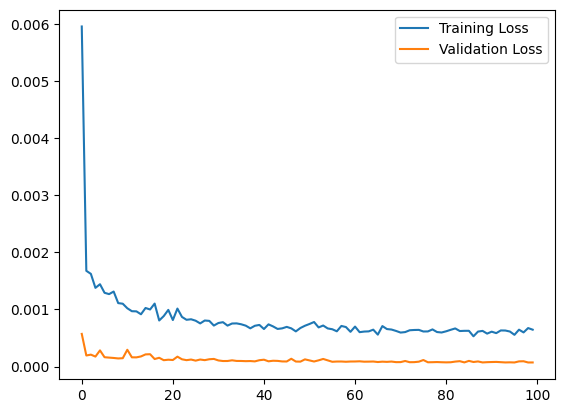

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
def forecast_future_values(model, X, num_days):
    forecast = []
    current_sequence = X[-seq_length:]
    for _ in range(num_days):
        next_value = model.predict(current_sequence.reshape(1, seq_length, 1))[0][0]
        forecast.append(next_value)
        current_sequence = np.append(current_sequence[1:], next_value)
    return forecast


In [15]:
future_forecast = forecast_future_values(model, X_val[-1], 6)
actual_prices = scaler.inverse_transform(y_val[-6:].reshape(-1, 1))
predicted_prices = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))


1/1 [==============================] - 0s 20ms/step


In [16]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Inverse transform the scaled predicted prices
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)


15/15 [==============================] - 0s 3ms/step


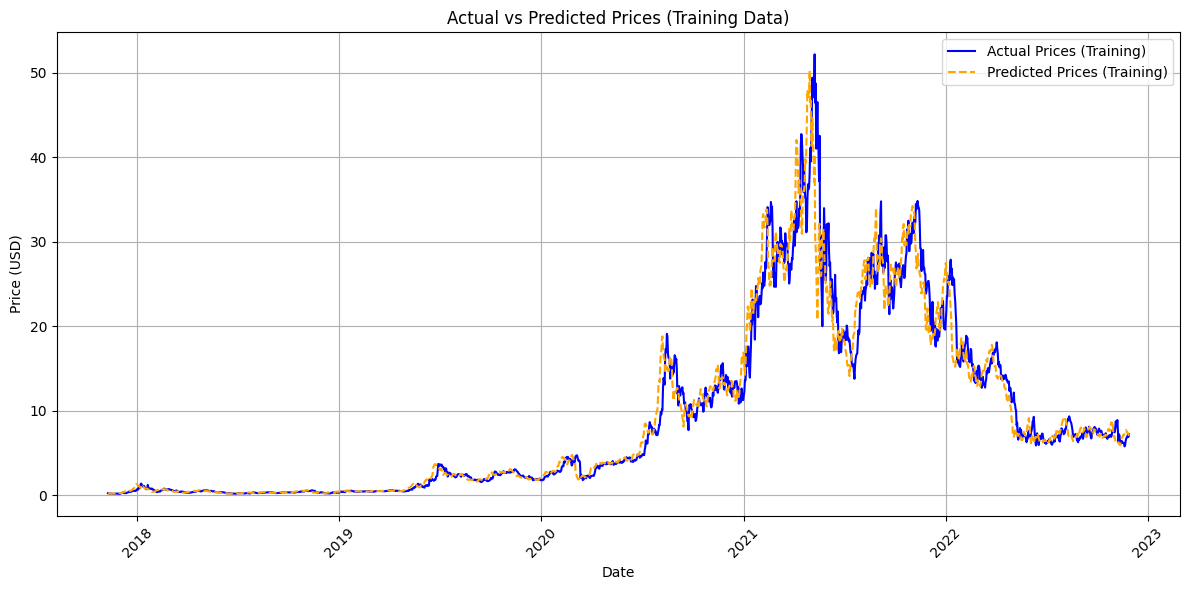

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(link_data.index[:train_size], link_data['Close'][:train_size], label='Actual Prices (Training)', color='blue')
plt.plot(link_data.index[:train_size][-len(y_train_pred_inv):], y_train_pred_inv, label='Predicted Prices (Training)', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

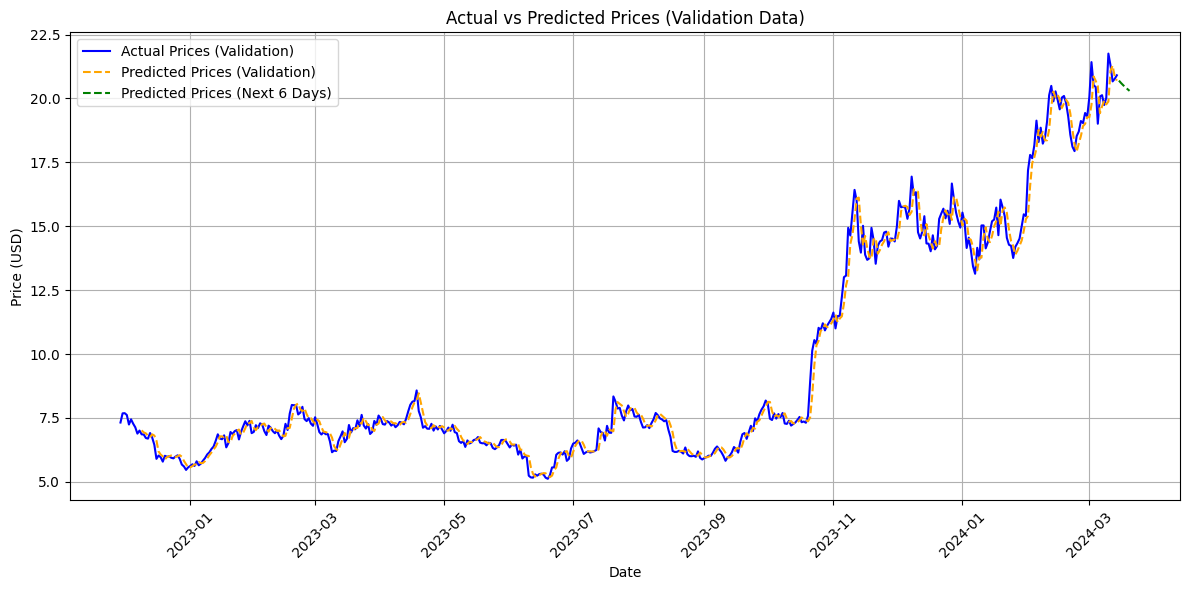

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(link_data.index[train_size:], link_data['Close'][train_size:], label='Actual Prices (Validation)', color='blue')
plt.plot(link_data.index[train_size:][-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted Prices (Validation)', linestyle='dashed', color='orange')
predicted_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=6)
plt.plot(predicted_dates, predicted_prices, label='Predicted Prices (Next 6 Days)', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Prices (Validation Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
last_date = link_data.index[-1]

next_six_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=6)

print("Predicted Prices for the Next 6 Days (from March 16, 2024):")
for i, (date, price) in enumerate(zip(next_six_days, predicted_prices), start=1):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]} USD")

Predicted Prices for the Next 6 Days (from March 16, 2024):
2024-03-15: 20.69722557067871 USD
2024-03-16: 20.601970672607422 USD
2024-03-17: 20.518299102783203 USD
2024-03-18: 20.4403018951416 USD
2024-03-19: 20.366579055786133 USD
2024-03-20: 20.296215057373047 USD


In [23]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.7018360618395986
